In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [51]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

<Axes: ylabel='Frequency'>

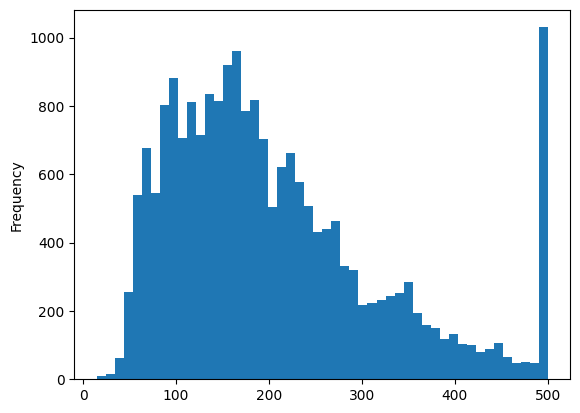

In [52]:
# Transform target
target *= 100
target.plot.hist(bins=50)

In [53]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(data, target)

# in-sample performance
from sklearn.metrics import mean_absolute_error
pred_insample = regressor.predict(data)
score_insample = mean_absolute_error(target, pred_insample)
print(f"In-sample prediction error (MAE): {score_insample:.3f}")

In-sample prediction error (MAE): 0.000


In [54]:
# Train/test split
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

# fit an OOP model
regressor.fit(data_train, target_train)

# in-sample performance
pred_insample = regressor.predict(data_train)
score_insample = mean_absolute_error(target_train, pred_insample)
print(f"In-sample prediction error (MAE): {score_insample:.3f}")

# OOP performance
pred_oop = regressor.predict(data_test)
score_oop = mean_absolute_error(target_test, pred_oop)
print(f"In-sample prediction error (MAE): {score_oop:.3f}")


In-sample prediction error (MAE): 0.000
In-sample prediction error (MAE): 46.326


In [55]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv_shuffle = ShuffleSplit(n_splits=40, test_size=0.3, random_state=42)
cv_shuffle_results = cross_validate(
    regressor, data, target, cv=cv_shuffle, scoring='neg_mean_absolute_error'
)

cv_shuffle_results = pd.DataFrame(cv_shuffle_results)
cv_shuffle_results.head(2)

,fit_time,score_time,test_score
0,0.137785,0.002543,-47.329969
1,0.130402,0.002686,-45.871795


In [56]:
cv_shuffle_results['MAE'] = -cv_shuffle_results['test_score']
cv_shuffle_results.head(2)

,fit_time,score_time,test_score,MAE
0,0.137785,0.002543,-47.329969,47.329969
1,0.130402,0.002686,-45.871795,45.871795


<Axes: ylabel='Frequency'>

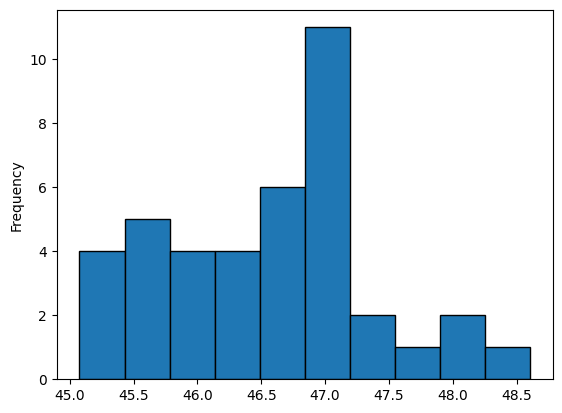

In [57]:
cv_shuffle_results['MAE'].plot.hist(bins=10, edgecolor='black')

<Axes: ylabel='Frequency'>

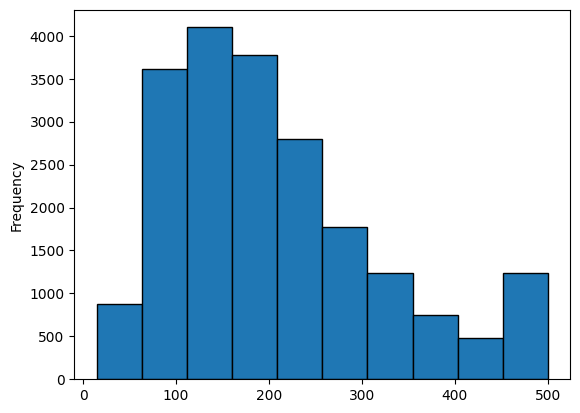

In [58]:
target.plot.hist(bins=10, edgecolor='black')

In [59]:
# Overfit-generalization-underfit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
cv_results = cross_validate(
    regressor,
    data, 
    target,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=4)
cv_results = pd.DataFrame(cv_results)


<Axes: ylabel='Frequency'>

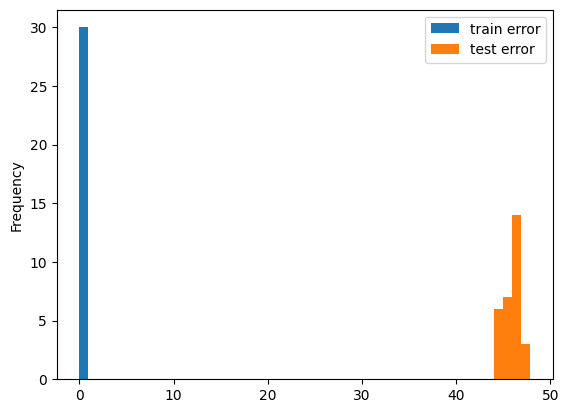

In [60]:
scores = pd.DataFrame()
scores[['train error', 'test error']] = -cv_results[['train_score', 'test_score']]
scores.plot.hist(bins=50)

CPU times: total: 46.9 ms
Wall time: 5 s


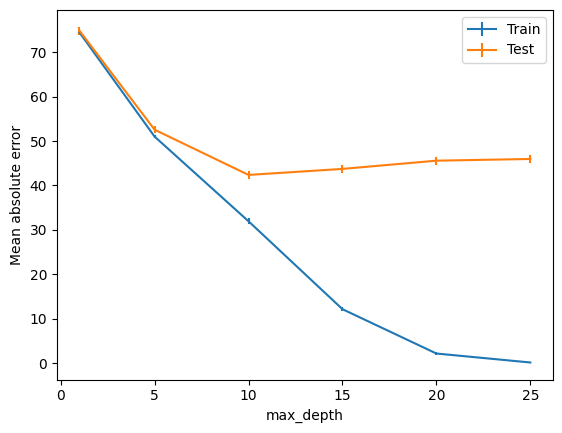

In [61]:
%%time

from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    regressor, data, target,
    param_name='max_depth', param_range=max_depth,
    cv=cv, scoring='neg_mean_absolute_error',
    negate_score=True,
    std_display_style='errorbar',
    n_jobs=4
)

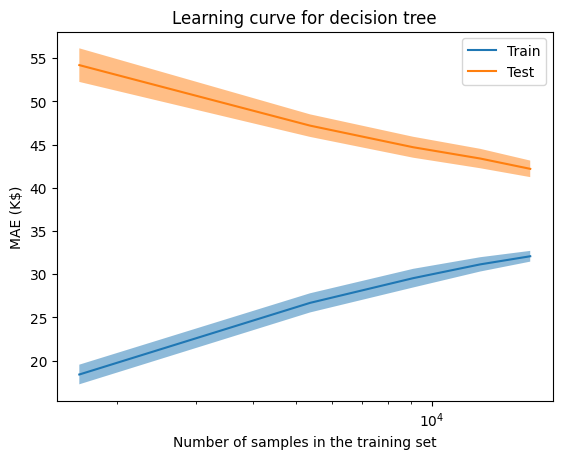

In [62]:
# Reset max_depth based on hyperparameter tuning above
regressor = DecisionTreeRegressor(max_depth=10)

# Set different training sizes
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

# Reset CV
cv = ShuffleSplit(n_splits=30, test_size=0.2)

# Plot the learning curve
from sklearn.model_selection import LearningCurveDisplay

disp = LearningCurveDisplay.from_estimator(
    regressor, data, target,
    train_sizes=train_sizes, cv=cv,
    score_type='both', # both train and test errors
    scoring='neg_mean_absolute_error',
    negate_score=True,
    score_name='MAE (K$)',
    n_jobs=4    
)
_ = disp.ax_.set(xscale='log', title='Learning curve for decision tree')

In [63]:
import pandas as pd

blood_transfusion = pd.read_csv("data/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

In [65]:
from sklearn.dummy import DummyClassifier
model_dummy = DummyClassifier(strategy='most_frequent')

from sklearn.model_selection import cross_validate
cv_dummy = cross_validate(model_dummy, data, target, cv=10)
cv_dummy['test_score'].mean()



np.float64(0.762054054054054)

In [66]:
# Using balanced class representation
cv_dummy = cross_validate(model_dummy, data, target, cv=10, scoring='balanced_accuracy')
cv_dummy['test_score'].mean()

np.float64(0.5)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
pipe_knn


,steps,"[('standardscaler', ...), ('kneighborsclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [77]:
model_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
cv_knn = cross_validate(model_knn, data, target, cv=10, 
                        scoring='balanced_accuracy', return_train_score=True)
print(f"Train accuracy: {cv_knn['train_score'].mean():.3f}")
print(f"Test accuracy: {cv_knn['test_score'].mean():3f}")

Train accuracy: 0.888
Test accuracy: 0.472747


In [78]:
model_knn.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))],
 'transform_input': None,
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(n_neighbors=1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

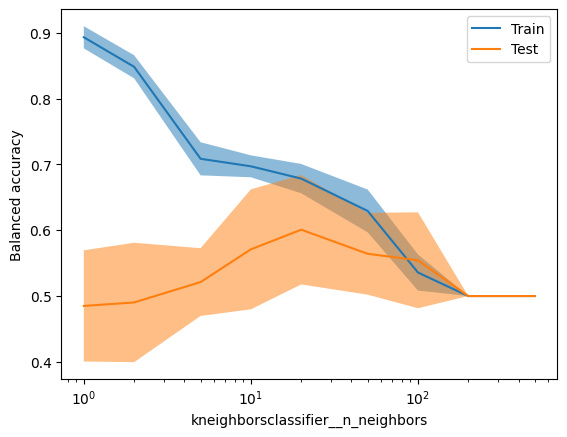

In [ ]:
# Hyperparameter tuning (n_neighbors)
from sklearn.model_selection import ValidationCurveDisplay

param_range = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])
model_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
disp = ValidationCurveDisplay.from_estimator(
    model_knn, data, target,
    param_name='kneighborsclassifier__n_neighbors',
    param_range=param_range,
    scoring='balanced_accuracy',
    n_jobs=4
)


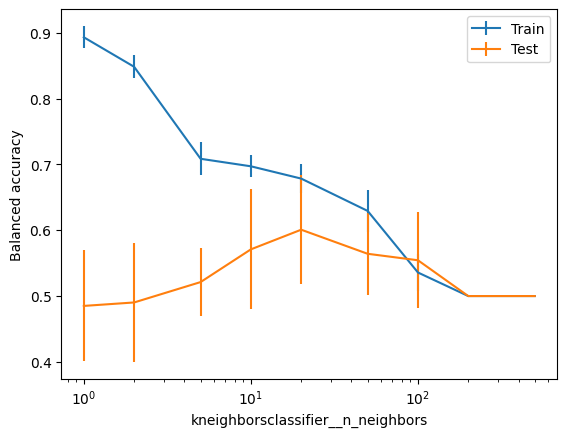

In [85]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_range = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])

disp = ValidationCurveDisplay.from_estimator(
    model,
    data,
    target,
    param_name="kneighborsclassifier__n_neighbors",
    param_range=param_range,
    scoring="balanced_accuracy",
    std_display_style="errorbar",
    n_jobs=2,
)

# Example 1—Comparing overfitting and underfitting
[scikit-learn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)

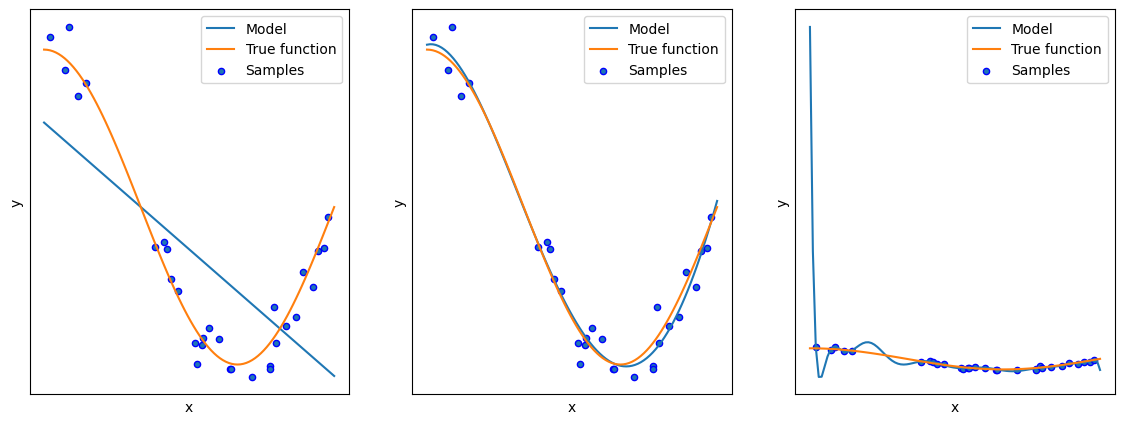

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks=(), yticks=()) # no tick marks/labels
    
    polinomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ('polinomial_features', polinomial_features),
            ('linear_regression', linear_regression)
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)
    
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, 
        scoring='neg_mean_squared_error', cv=10
    )
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label='Model')
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label='Samples')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc='best')
    

# Example 2—Effect of Model Regularization on Training and Test Error
[scikit-learn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html#sphx-glr-auto-examples-model-selection-plot-train-error-vs-test-error-py)

In [92]:
# Generate sample data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

n_samples_train, n_samples_test, n_features = 150, 300, 500
X, y, true_coef = make_regression(
    n_samples=n_samples_train + n_samples_test,
    n_features=n_features,
    n_informative=50,
    shuffle=False,
    noise=1.0,
    coef=True,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=n_samples_train, test_size=n_samples_test, shuffle=False
)

In [94]:
# Define our elastic net model
from sklearn.linear_model import ElasticNet

# l1_ratio splits between ridge and lasso (0.9 means mostly lasso)
# positive=True, because our simulation above assumes all coefs are positive
enet = ElasticNet(l1_ratio=0.9, positive=True, max_iter=10_000)

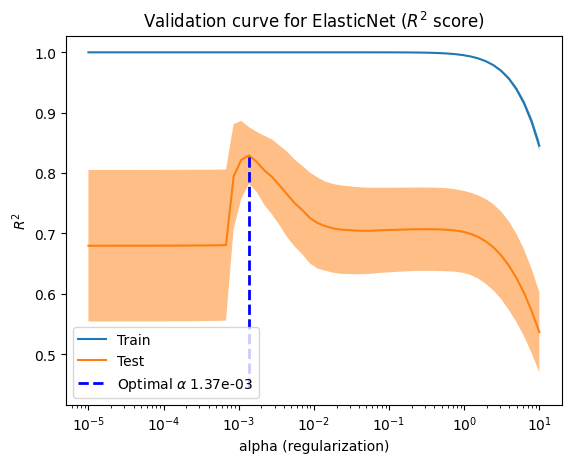

In [103]:
# Hyperparameter tuning
alphas = np.logspace(-5, 1, 60)
disp = ValidationCurveDisplay.from_estimator(
    enet, X_train, y_train,
    param_name='alpha', param_range=alphas,
    scoring='r2', n_jobs=8, score_type='both'
)
disp.ax_.set(
    title=r'Validation curve for ElasticNet ($R^2$ score)',
    xlabel=r'alpha (regularization)',
    ylabel='$R^2$'
)

test_scores_mean = disp.test_scores.mean(axis=1)
idx = np.argmax(test_scores_mean)
disp.ax_.vlines(
    alphas[idx], # x-axis location
    disp.ax_.get_ylim()[0], # bottom of y-axis
    test_scores_mean[idx], # top of y-axis
    color='b',
    linewidth=2,
    linestyle='--',
    label=f'Optimal $\\alpha$ {alphas[idx]:.2e}'
)
_ = disp.ax_.legend(loc='best')

In [104]:
# Reset the enet model using the optimal parameter
enet.set_params(alpha=alphas[idx]).fit(X_train, y_train)
print(f"Test score: {enet.score(X_test, y_test):.3f}")

Test score: 0.884


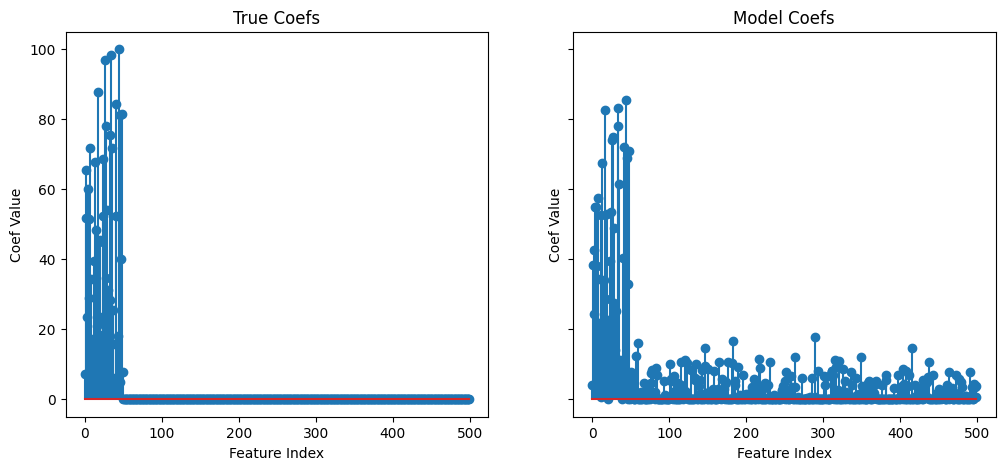

In [107]:
# Plot the true vs estimated coefs
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for ax, coef, title in zip(axs, [true_coef, enet.coef_], ['True', 'Model']):
    ax.stem(coef)
    ax.set(
        title=f"{title} Coefs",
        xlabel="Feature Index",
        ylabel="Coef Value"
    )